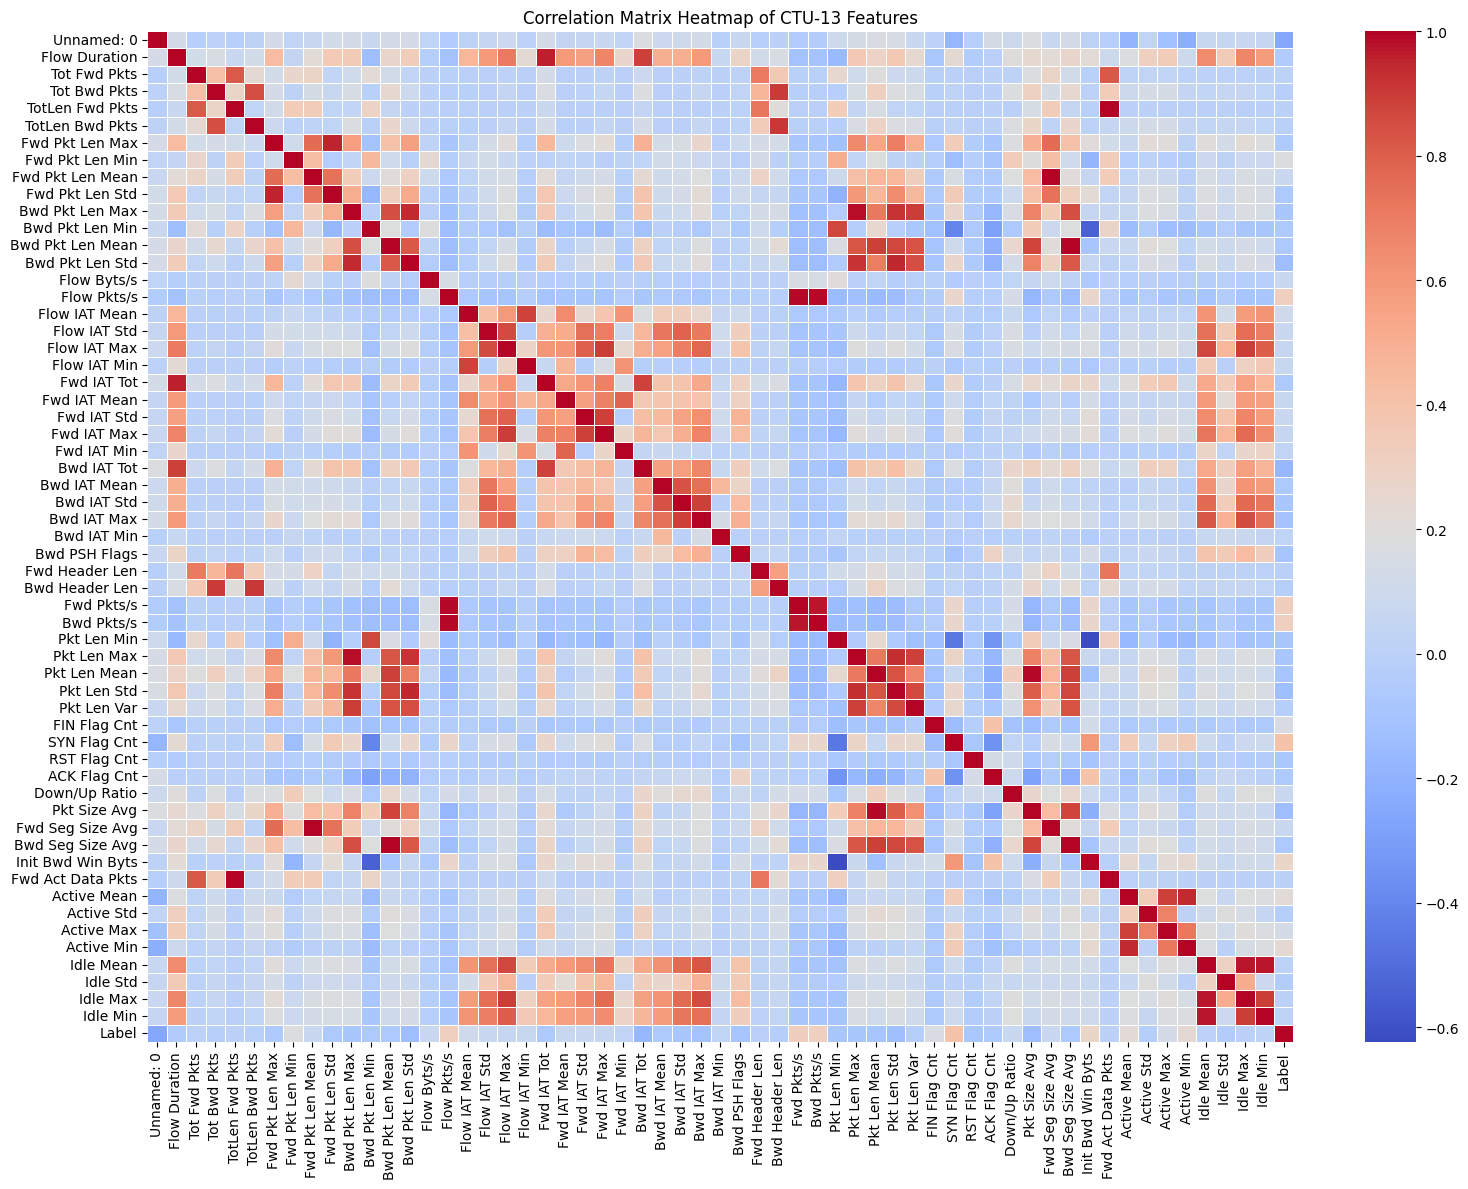

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


normal_df = pd.read_csv(r"D:\Network-Anomaly-Detector\CTU13-CSV-Dataset-main\CTU13_Normal_Traffic.csv")
attack_df = pd.read_csv(r"D:\Network-Anomaly-Detector\CTU13-CSV-Dataset-main\CTU13_Attack_Traffic.csv")


# Step 2: Combine datasets
combined_df = pd.concat([normal_df, attack_df], ignore_index=True)

# Step 3: Select numeric columns only
numeric_df = combined_df.select_dtypes(include=['number'])

# Step 4: Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Step 5: Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap of CTU-13 Features')
plt.tight_layout()
plt.show()


In [2]:
cor_target = correlation_matrix["Label"].abs()
top_features = cor_target.sort_values(ascending=False)
print(top_features)

Label                1.000000
SYN Flag Cnt         0.399345
Fwd Pkts/s           0.321803
Flow Pkts/s          0.321553
Bwd Pkts/s           0.316281
Init Bwd Win Byts    0.272205
Unnamed: 0           0.249973
Active Min           0.233415
Active Mean          0.214834
Fwd Pkt Len Min      0.178055
Bwd IAT Tot          0.169444
FIN Flag Cnt         0.162684
Bwd Pkt Len Std      0.140818
Active Max           0.136331
Pkt Size Avg         0.135065
Pkt Len Std          0.133065
Bwd IAT Max          0.106955
Flow IAT Mean        0.100653
Pkt Len Mean         0.092279
Bwd PSH Flags        0.091399
Bwd Pkt Len Max      0.089825
Pkt Len Max          0.085984
Pkt Len Min          0.085042
Bwd IAT Std          0.079210
RST Flag Cnt         0.075087
Down/Up Ratio        0.074137
Flow Byts/s          0.072444
Fwd Pkt Len Mean     0.071268
Fwd Seg Size Avg     0.071268
Flow IAT Std         0.070978
Fwd IAT Std          0.069234
Bwd Seg Size Avg     0.069158
Bwd Pkt Len Mean     0.069158
Flow IAT M

In [3]:
# Get top N features most correlated with 'Label'
top_n = 10  # or any number
top_features = cor_target.drop('Label').sort_values(ascending=False).head(top_n).index.tolist()

print("Top correlated features with Label:")
print(top_features)


Top correlated features with Label:
['SYN Flag Cnt', 'Fwd Pkts/s', 'Flow Pkts/s', 'Bwd Pkts/s', 'Init Bwd Win Byts', 'Unnamed: 0', 'Active Min', 'Active Mean', 'Fwd Pkt Len Min', 'Bwd IAT Tot']


In [11]:
import pandas as pd
import numpy as np

# 1. Load dataset
normal_df = pd.read_csv(r"D:\Network-Anomaly-Detector\CTU13-CSV-Dataset-main\CTU13_Normal_Traffic.csv")
attack_df = pd.read_csv(r"D:\Network-Anomaly-Detector\CTU13-CSV-Dataset-main\CTU13_Attack_Traffic.csv")

# 2. Label the datasets
normal_df["Label"] = "Benign"
attack_df["Label"] = "Malicious"

# 3. Combine datasets
df = pd.concat([normal_df, attack_df], ignore_index=True)

# 4. Features for tokenization
features = {
    'SYN Flag Cnt': 'SYN',
    'Fwd Pkts/s': 'FWD',
    'Flow Pkts/s': 'FLOW',
    'Bwd Pkts/s': 'BWD',
    'Init Bwd Win Byts': 'WIN',
    'Active Min': 'ACTMIN',
    'Active Mean': 'ACTMEAN',
    'Fwd Pkt Len Min': 'PKTLEN',
    'Bwd IAT Tot': 'IAT'
}

# 5. Discretize into tokens
labels = ['LOW', 'MEDIUM', 'HIGH']
n_bins = 3

# Dictionary to store discretized token strings for each feature
discretized = {}

for col, prefix in features.items():
    try:
        binned = pd.qcut(df[col], q=n_bins, labels=labels, duplicates='drop')
        discretized[prefix] = binned.map(lambda x: f"{prefix}_{x}")
    except Exception as e:
        print(f"Error processing {col}: {e}")
        discretized[prefix] = pd.Series(["MISSING"] * len(df))  # fallback

# 6. Combine tokens into DNA-like sequence
dna_df = pd.DataFrame(discretized)
df["Network_DNA"] = dna_df.apply(lambda row: "-".join(row.values), axis=1)

# 7. Show a few DNA sequences
print(df[["Network_DNA", "Label"]].head(10))

# 8. Optional: Save the sequences
# df[["Network_DNA", "Label"]].to_csv("network_dna_sequences.csv", index=False)


Error processing SYN Flag Cnt: Bin labels must be one fewer than the number of bin edges
Error processing Fwd Pkts/s: Bin labels must be one fewer than the number of bin edges
Error processing Init Bwd Win Byts: Bin labels must be one fewer than the number of bin edges
Error processing Active Min: Bin labels must be one fewer than the number of bin edges
Error processing Active Mean: Bin labels must be one fewer than the number of bin edges
Error processing Fwd Pkt Len Min: Bin labels must be one fewer than the number of bin edges
                                         Network_DNA   Label
0  MISSING-MISSING-FLOW_HIGH-BWD_HIGH-MISSING-MIS...  Benign
1  MISSING-MISSING-FLOW_HIGH-BWD_HIGH-MISSING-MIS...  Benign
2  MISSING-MISSING-FLOW_HIGH-BWD_HIGH-MISSING-MIS...  Benign
3  MISSING-MISSING-FLOW_MEDIUM-BWD_MEDIUM-MISSING...  Benign
4  MISSING-MISSING-FLOW_HIGH-BWD_HIGH-MISSING-MIS...  Benign
5  MISSING-MISSING-FLOW_MEDIUM-BWD_MEDIUM-MISSING...  Benign
6  MISSING-MISSING-FLOW_HIGH-BWD_HIG

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# 1. Tokenize Network DNA sequences (symbolic words)
sequences = df["Network_DNA"].astype(str).tolist()

tokenizer = Tokenizer(lower=False, split='-')  # case sensitive and split by dash
tokenizer.fit_on_texts(sequences)
seqs = tokenizer.texts_to_sequences(sequences)

# 2. Pad sequences to equal length
maxlen = max(len(seq) for seq in seqs)  # or use a fixed number like 20
X = pad_sequences(seqs, padding='post', maxlen=maxlen)

# 3. Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Label"])
y = to_categorical(y)  # one-hot encode for categorical classification

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ImportError: Traceback (most recent call last):
  File "c:\Users\Hello\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [4]:
! pip install pandas pyarrow



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
! pip install fastparquet
import pandas as pd
# Load the Parquet file using PyArrow (default)
df = pd.read_parquet(r"D:\Network-Anomaly-Detector\CTU13-CSV-Dataset-main\1-Neris-20110810.binetflow.parquet")
print(df.head())



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


        dur proto    dir state  stos  dtos  tot_pkts  tot_bytes  src_bytes  \
0  1.026539   tcp     ->  S_RA   0.0   0.0         4        276        156   
1  1.009595   tcp     ->  S_RA   0.0   0.0         4        276        156   
2  3.056586   tcp     ->  SR_A   0.0   0.0         3        182        122   
3  3.111769   tcp     ->  SR_A   0.0   0.0         3        182        122   
4  3.083411   tcp     ->  SR_A   0.0   0.0         3        182        122   

                                    label                  Family  
0  flow=Background-Established-cmpgw-CVUT  20110810.binetflow.csv  
1  flow=Background-Established-cmpgw-CVUT  20110810.binetflow.csv  
2             flow=Background-TCP-Attempt  20110810.binetflow.csv  
3             flow=Background-TCP-Attempt  20110810.binetflow.csv  
4             flow=Background-TCP-Attempt  20110810.binetflow.csv  


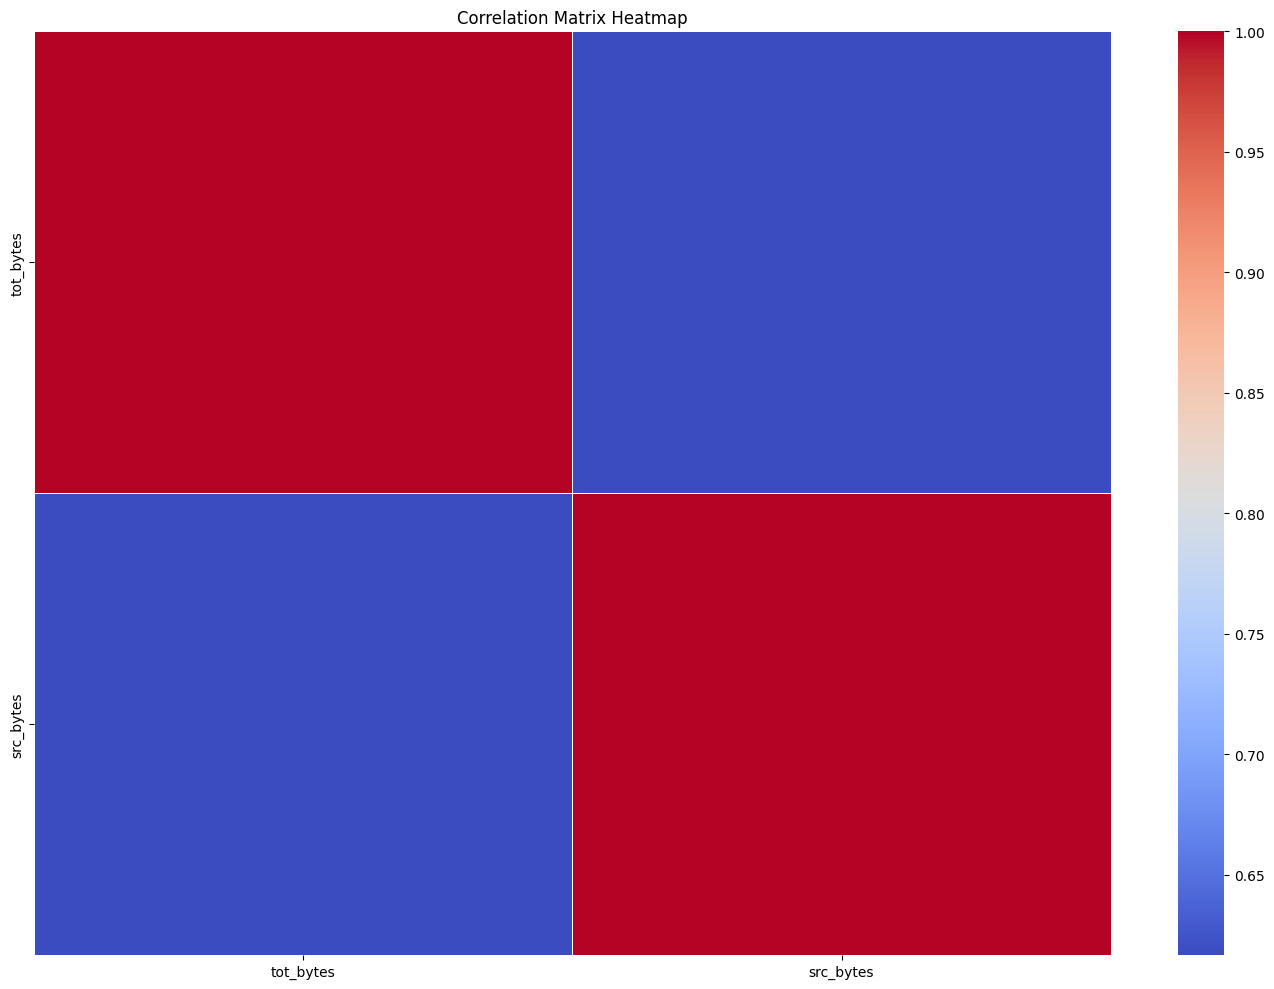

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the parquet file
file_path = r"D:\archive (1)\1-Neris-20110810.binetflow.parquet"
df = pd.read_parquet(file_path)

# Optional: drop non-numeric columns (like Label, IPs, etc.)
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()


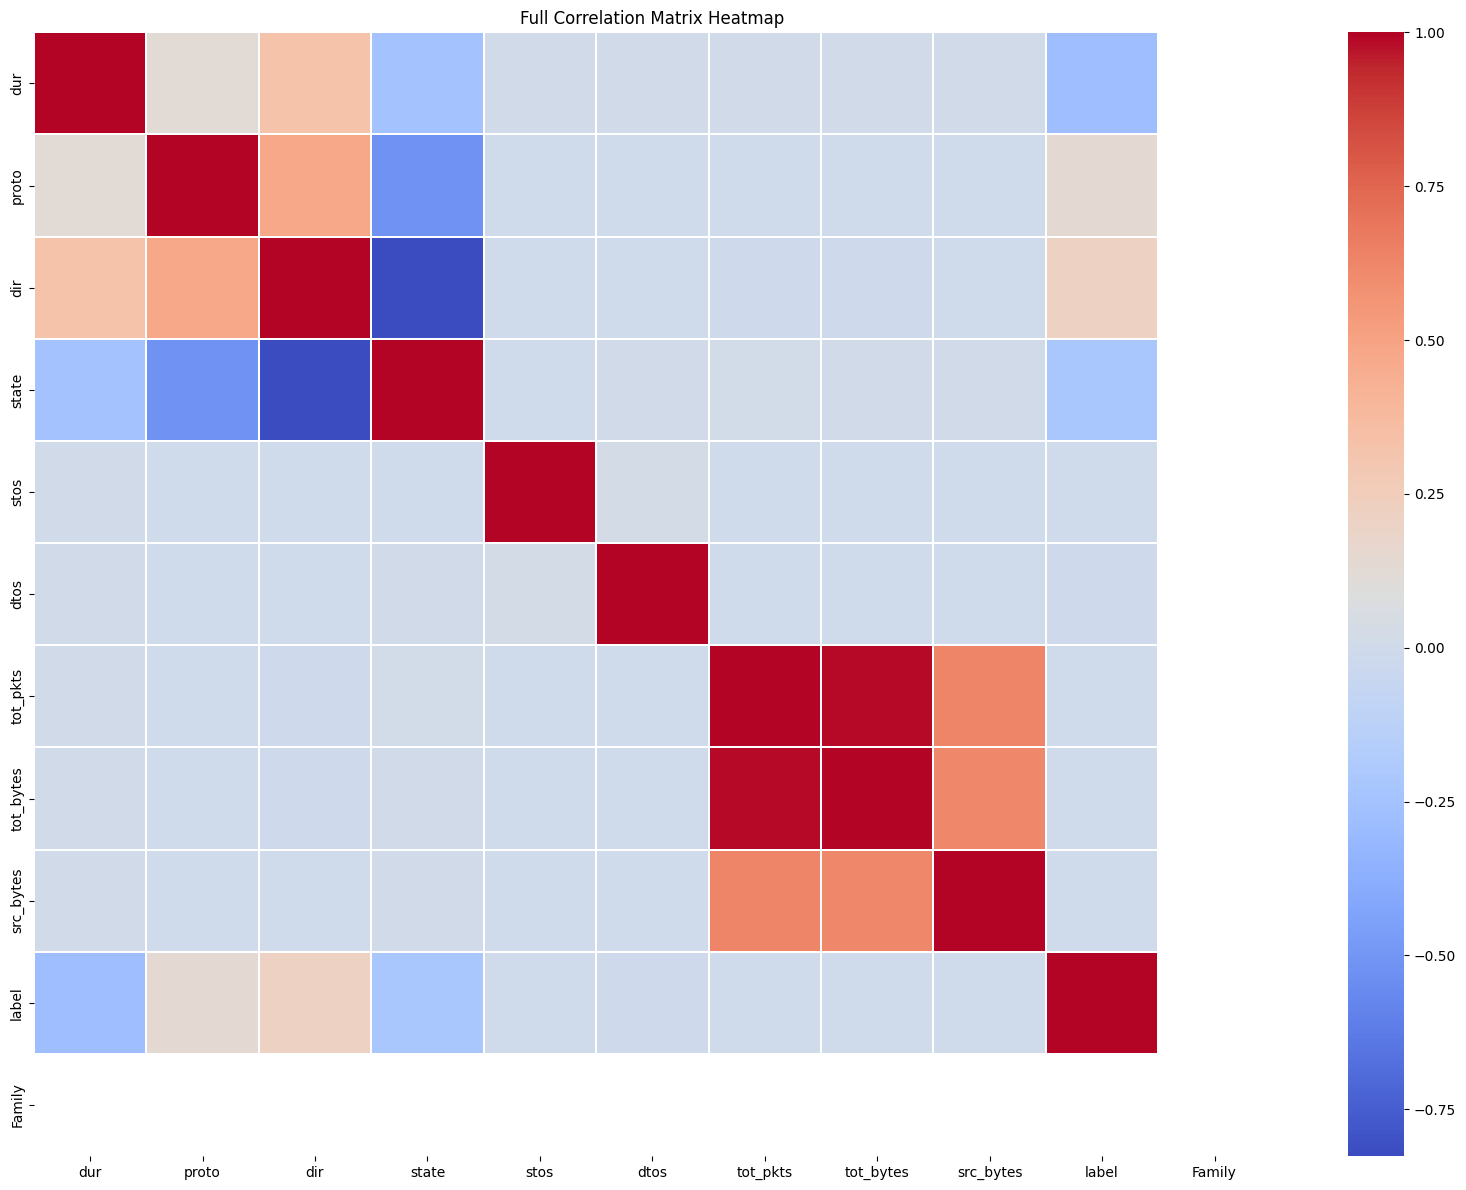

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Step 1: Load parquet file
file_path = r"D:\archive (1)\1-Neris-20110810.binetflow.parquet"
df = pd.read_parquet(file_path)

# Step 2: Encode categorical features
# Loop through each column and encode non-numeric columns
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # Apply Label Encoding
        le = LabelEncoder()
        try:
            df[col] = le.fit_transform(df[col].astype(str))
        except:
            print(f"Encoding failed for column: {col}")

# Step 3: Compute correlation matrix
correlation_matrix = df.corr()

# Step 4: Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.3)
plt.title("Full Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()
